http://shichaoji.com/tag/topic-modeling-python-lda-visualization-gensim-pyldavis-nltk/

## Import packages 

In [1]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import nltk, re, pprint
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
nltk.download('wordnet')
from nltk.stem.wordnet import WordNetLemmatizer
import sys
% matplotlib inline
import matplotlib.pyplot as plt
import gensim
#sys.setdefaultencoding("utf-8")

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Curri\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Create list of stopwords from custom list and built-in library

In [3]:
from nltk.corpus import stopwords
ENGLISH_STOP_WORDS = set(stopwords.words('english'))
random_words = ["miss", "mr", "mrs", "said", "jr", "ms"]
nytimes_words = ["photo", "nytimes", "nytoday", "com", "www"]
custom_words = "___ saying hours told pareles news people like new thats le soho robert often chelsea fifth going scott john michael el time think saturday _____ briefing brantley bird rd give bleecker though nearly los bay dr side downtown theyre miller williams thcentury didnt dont central wife posted eastern want email red hook try take long summer winter minute long ago hour stories weekdays sundays rundown latest look sign let convention week american year say house york make know day late comedy host cbs report character guest night admission admissions charge fee johnson petrusich smith ratliff jersey staten chris daily manhattan wilson bronx cover reservations reservation dunning tickets tonight broadway chinen meeting japanese moses sponsored island information state united bowery little last also life much each two many tomorrow free org th minimum little Sonneh feet street man st door play one would years get even could way back around avenue streets says go really made something still got came come right always sanneh percent nd near co la sisario go says east village advance clinton san hes cotter made wa ha harlem de west thing sold another still around called things city see well beach men women woman man"
month_time_dayofweek = "january february march april may june july august september october november december sunday monday tuesday wednesday thursday friday morning noon night weekday weekend evening mondays tuesdays wednesdays thursdays fridays saturdays sundays jan feb mar aprl jun jul aug sep oct nov dec mon tues weds thurs fri sat sun pm month"
numbers_list = ["one", "two", "three", "four", "five", "six", "seven", "eight", "nine", "ten"]
custom_words_list = custom_words.split()
month_time_day_list = month_time_dayofweek.split()

STOPLIST = set(stopwords.words('english') + random_words + numbers_list + list(month_time_day_list) + list(ENGLISH_STOP_WORDS) + nytimes_words + custom_words_list)
STOPLIST = list(STOPLIST)

##  Create dataframe, taking each corpus document and appending it to a column called "Contents"
**Note: each article was saved as an individual txt document with the date and URL in the file name 

In [4]:
path = 'corpus/williamsburg_finalcorpus'

myfolder = os.listdir(path)
articles = []

slash = '/'

for filename in myfolder:
    if filename.endswith('.txt'):
        date = filename[0:10]
        with open(path + slash + filename) as fh:
            contents = fh.read()
            articles.append([contents, date])
            
raw = pd.DataFrame(articles, columns=['Contents','Date'])


### Drop duplicates

In [5]:
raw_no_duplicates = raw.drop_duplicates("Contents")

### Generate new rows for month and year

In [6]:
raw_no_duplicates["Contents_Lower"] = raw_no_duplicates["Contents"].str.lower()
raw_no_duplicates["Contents_Clean"] = raw_no_duplicates["Contents_Lower"].apply(lambda x: x.replace("\n", " "))
raw_no_duplicates["Year"] = raw_no_duplicates["Date"].astype(str).str[0:4]
raw_no_duplicates["Month"] = raw_no_duplicates["Date"].astype(str).str[5:7]
raw_no_duplicates["Date_by_Month"] = raw_no_duplicates["Month"].map(str) + '-' + raw_no_duplicates["Year"].map(str)

### Clean and preprocess text by: removing digits, stop words, and punctuation. Then tokenize words and lemmatize for analysis

In [7]:
import string
exclude = set(string.punctuation)

lemma = WordNetLemmatizer()

def is_good_utf8(str):
    try:
        str.decode("utf-8")
        return True
    except:
        return False
    
raw_no_duplicates["Contents_Clean"] = raw_no_duplicates["Contents_Clean"].apply(lambda x: ''.join([c for c in x if not c.isdigit()]))
raw_no_duplicates["Contents_nopunc"] = raw_no_duplicates["Contents_Clean"].apply(lambda x: ''.join([c for c in x if c not in exclude]))
raw_no_duplicates['Contents_Tokenized']=raw_no_duplicates["Contents_nopunc"].apply(lambda x : filter(is_good_utf8, filter(None,x.split(" "))))
raw_no_duplicates['Contents_decode']=raw_no_duplicates['Contents_Tokenized'].apply(lambda x: [word.decode('utf-8', ) for word in x])
raw_no_duplicates["Contents_Lemma"]=raw_no_duplicates["Contents_decode"].apply(lambda x : " ".join(lemma.lemmatize(word) for word in x))



## Check dataframe output for cleaning steps

In [9]:
raw_no_duplicates.head()

,Contents,Date,Contents_Lower,Contents_Clean,Year,Month,Date_by_Month,Contents_nopunc,Contents_Tokenized,Contents_decode,Contents_Lemma
0,"EVEN people with faith in nothing, people who ...",2000-01-02,"even people with faith in nothing, people who ...","even people with faith in nothing, people who ...",2000,01,01-2000,even people with faith in nothing people who b...,"[even, people, with, faith, in, nothing, peopl...","[even, people, with, faith, in, nothing, peopl...",even people with faith in nothing people who b...
1,"Correction Appended\nTENEMENTS, yes. Luxury ho...",2000-01-06,"correction appended\ntenements, yes. luxury ho...","correction appended tenements, yes. luxury hou...",2000,01,01-2000,correction appended tenements yes luxury housi...,"[correction, appended, tenements, yes, luxury,...","[correction, appended, tenements, yes, luxury,...",correction appended tenement yes luxury housin...
2,"Two years ago, Joe, the man I lived with, sugg...",2000-01-14,"two years ago, joe, the man i lived with, sugg...","two years ago, joe, the man i lived with, sugg...",2000,01,01-2000,two years ago joe the man i lived with suggest...,"[two, years, ago, joe, the, man, i, lived, wit...","[two, years, ago, joe, the, man, i, lived, wit...",two year ago joe the man i lived with suggeste...
3,IF they didn't play their luck out in furnitur...,2000-01-20,if they didn't play their luck out in furnitur...,if they didn't play their luck out in furnitur...,2000,01,01-2000,if they didnt play their luck out in furniture...,"[if, they, didnt, play, their, luck, out, in, ...","[if, they, didnt, play, their, luck, out, in, ...",if they didnt play their luck out in furniture...
4,"FOR years, Tequila's on Columbus held out a we...",2000-01-26,"for years, tequila's on columbus held out a we...","for years, tequila's on columbus held out a we...",2000,01,01-2000,for years tequilas on columbus held out a welc...,"[for, years, tequilas, on, columbus, held, out...","[for, years, tequilas, on, columbus, held, out...",for year tequila on columbus held out a welcom...


### Generate NMF and LDA Outputs

In [11]:
#function to display the topics and terms that make up each topic for both models -- will be called at the end

def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

#NMF Model
tfidf_vectorizer = TfidfVectorizer(max_df = 0.4, min_df = 15,
                                   stop_words = STOPLIST)
tfidf = tfidf_vectorizer.fit_transform(raw_no_duplicates["Contents_Lemma"])
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
nmf = NMF(n_components = 10, random_state=1, alpha=.1, l1_ratio=.5).fit(tfidf)

In [12]:
#LDA Model
no_features = 1000

#specify number of topic words
no_top_words = 20
no_topics = 10

tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=no_features, stop_words=STOPLIST)
tf = tf_vectorizer.fit_transform(raw_no_duplicates["Contents_Lemma"])
tf_feature_names = tf_vectorizer.get_feature_names()
lda = LatentDirichletAllocation(n_topics=no_topics, max_iter=5, learning_method='online', learning_offset=50.,random_state=0).fit(tf)




C:\Users\Curri\Miniconda2\lib\site-packages\sklearn\decomposition\online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


In [51]:
tfidf

<1477x9185 sparse matrix of type '<type 'numpy.float64'>'
	with 589680 stored elements in Compressed Sparse Row format>

In [52]:
tf

<1477x1000 sparse matrix of type '<type 'numpy.int64'>'
	with 275895 stored elements in Compressed Sparse Row format>

In [15]:
print_top_words(nmf, tfidf_feature_names, 10)

Topic #0:
band song album rock guitar ballroom pop hall singer theater
Topic #1:
store friend business shop artist rent party apartment school company
Topic #2:
museum painting gallery artist exhibition sculpture photograph drawing image object
Topic #3:
dance ticket ballet opera theater program company choreographer dancer performance
Topic #4:
tour museum student child exhibition garden walking corner walk history
Topic #5:
jazz ticket band saxophonist song drummer pianist trio bassist quartet
Topic #6:
restaurant chef wine menu food dish beer diner opened burger
Topic #7:
post mayor bloomberg school police official authority department officer council
Topic #8:
apartment developer housing development price unit project market million buyer
Topic #9:
theater preview musical production directs cast close stage drama revival
()


In [16]:
print_top_words(lda, tf_feature_names, no_top_words)


Topic #0:
theater show film musical open preview story movie production director close stage cast begin festival book music young actor star
Topic #1:
park tour museum child student brooklyn garden exhibition member center art lower history place open society corner walk walking square
Topic #2:
band music song rock album record show club brooklyn first pop sound party group hiphop guitar label fan black since
Topic #3:
artist art space neighborhood party work studio gallery place friend gay brooklyn young loft live hipster rent area scene book
Topic #4:
bar restaurant brooklyn coffee food place beer wine drink owner good opened room chef menu hotel open cocktail shop first
Topic #5:
building apartment brooklyn neighborhood development million price market housing area project plan park space school developer real home estate rent
Topic #6:
art museum show work artist gallery painting exhibition sculpture drawing photograph image contemporary modern collection design object close video

## Generate NMF Visualization

In [149]:
#NMF Topic Names
NMF_Topic_Names = {0: "Live Music",
               1: "Neighborhood Life",
               2: "Galleries and Art Exhibitions",
               3: "Dance & Theater",
               4: "Tours & Tourism",
               5: "Jazz consumption",
               6: "Food & Restaurant Culture",
               7: "Public Safety", 
               8: "Residential Development", 
              9: "Entertainment Production"}

In [150]:
transformed_data_NMF = nmf.transform(tfidf)
len(transformed_data_NMF)

1477

In [151]:
transformed_data_NMF

array([[ 0.        ,  0.09764479,  0.        , ...,  0.        ,
         0.07844453,  0.        ],
       [ 0.        ,  0.11301382,  0.        , ...,  0.        ,
         0.13217717,  0.        ],
       [ 0.        ,  0.11598278,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ..., 
       [ 0.00555913,  0.02034714,  0.4046028 , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.23384471,  0.00167265,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.01646532,  0.05038263,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [152]:
def zero_equals_1(x): 
    if x != 0:
        return 1
    else:
        return x

In [153]:
transformed_data_NMF = pd.DataFrame(transformed_data_NMF)
article_topics_NMF = transformed_data_NMF.applymap(zero_equals_1)
raw_data_NMF = raw_no_duplicates.reset_index()
article_topics_NMF["Date"] = raw_data_NMF["Date_by_Month"]
article_topics_NMF["Year"] = raw_data_NMF["Year"]
article_topics_NMF["Article_Num"] = range(1, len(article_topics_NMF) + 1)
melted_df_NMF = pd.melt(article_topics_NMF, id_vars = ["Article_Num", "Date", "Year"], var_name = "Topic_Num")

In [141]:
#melted_df_NMF = melted_df_NMF[-melted_df_NMF["Topic_Num"].isin([0, 10])]

In [154]:
topic_num_to_name_NMF = pd.DataFrame.from_dict(NMF_Topic_Names, orient = "index").reset_index()
topic_num_to_name_NMF.columns = ["Topic_Num", "NMF_Topic_Name"]
final_df_NMF = melted_df_NMF.merge(topic_num_to_name_NMF, on = "Topic_Num")

In [155]:
#OVERALL NMF TOPICS
overall_NMF_topic = pd.DataFrame({"Entertainment & Leisure": [0,2,3,5,6,9],
                     "Neighborhood Development": [1,4,7,8,"Nan","Nan"]})
melted_ot_NMF = pd.melt(overall_NMF_topic)
melted_ot_NMF = melted_ot_NMF[melted_ot_NMF["value"] != "NaN"]
melted_ot_NMF.columns = ["NMF Overall Topic", "Topic_Num"]

In [156]:
final_df_NMF = final_df_NMF.merge(melted_ot_NMF, on = "Topic_Num")

In [157]:
final_df_NMF = final_df_NMF.groupby(["Year", "Topic_Num", "NMF_Topic_Name", "NMF Overall Topic"]).sum().reset_index()

In [158]:
final_df_NMF = final_df_NMF.rename(columns={'NMF_Topic_Name': 'NMF Topic Name'})

In [159]:
final_df_NMF

,Year,Topic_Num,NMF Topic Name,NMF Overall Topic,Article_Num,value
0,2000,0,Live Music,Entertainment & Leisure,2080,17.0
1,2000,1,Neighborhood Life,Neighborhood Development,2080,64.0
2,2000,2,Galleries and Art Exhibitions,Entertainment & Leisure,2080,23.0
3,2000,3,Dance & Theater,Entertainment & Leisure,2080,5.0
4,2000,4,Tours & Tourism,Neighborhood Development,2080,19.0
5,2000,5,Jazz consumption,Entertainment & Leisure,2080,9.0
6,2000,6,Food & Restaurant Culture,Entertainment & Leisure,2080,14.0
7,2000,7,Public Safety,Neighborhood Development,2080,10.0
8,2000,8,Residential Development,Neighborhood Development,2080,17.0
9,2000,9,Entertainment Production,Entertainment & Leisure,2080,3.0


In [189]:
final_sum_NMF = final_df_NMF.groupby(["Year"])["value"].sum().reset_index()

In [190]:
final_sum_NMF

,Year,value
0,2000,181.0
1,2001,238.0
2,2002,378.0
3,2003,408.0
4,2004,364.0
5,2005,246.0
6,2006,341.0
7,2007,589.0
8,2008,610.0
9,2009,465.0


In [191]:
pro_df_NMF=pd.merge(left=final_df_NMF, right=final_sum_NMF, left_on='Year',right_on='Year',how='left')
pro_df_NMF

,Year,Topic_Num,NMF Topic Name,NMF Overall Topic,Article_Num,value_x,value_y
0,2000,0,Live Music,Entertainment & Leisure,2080,17.0,181.0
1,2000,1,Neighborhood Life,Neighborhood Development,2080,64.0,181.0
2,2000,2,Galleries and Art Exhibitions,Entertainment & Leisure,2080,23.0,181.0
3,2000,3,Dance & Theater,Entertainment & Leisure,2080,5.0,181.0
4,2000,4,Tours & Tourism,Neighborhood Development,2080,19.0,181.0
5,2000,5,Jazz consumption,Entertainment & Leisure,2080,9.0,181.0
6,2000,6,Food & Restaurant Culture,Entertainment & Leisure,2080,14.0,181.0
7,2000,7,Public Safety,Neighborhood Development,2080,10.0,181.0
8,2000,8,Residential Development,Neighborhood Development,2080,17.0,181.0
9,2000,9,Entertainment Production,Entertainment & Leisure,2080,3.0,181.0


In [192]:
pro_df_NMF.loc[:,"Topic Probability"]=pro_df_NMF.value_x /pro_df_NMF.value_y
pro_df_NMF = pro_df_NMF.rename(index=str, columns={"value_x": "Topic Sum", "value_y": "Year Sum", "NMF_Topic_Name": "Topic Name"})
pro_df_NMF

,Year,Topic_Num,NMF Topic Name,NMF Overall Topic,Article_Num,Topic Sum,Year Sum,Topic Probability
0,2000,0,Live Music,Entertainment & Leisure,2080,17.0,181.0,0.093923
1,2000,1,Neighborhood Life,Neighborhood Development,2080,64.0,181.0,0.353591
2,2000,2,Galleries and Art Exhibitions,Entertainment & Leisure,2080,23.0,181.0,0.127072
3,2000,3,Dance & Theater,Entertainment & Leisure,2080,5.0,181.0,0.027624
4,2000,4,Tours & Tourism,Neighborhood Development,2080,19.0,181.0,0.104972
5,2000,5,Jazz consumption,Entertainment & Leisure,2080,9.0,181.0,0.049724
6,2000,6,Food & Restaurant Culture,Entertainment & Leisure,2080,14.0,181.0,0.077348
7,2000,7,Public Safety,Neighborhood Development,2080,10.0,181.0,0.055249
8,2000,8,Residential Development,Neighborhood Development,2080,17.0,181.0,0.093923
9,2000,9,Entertainment Production,Entertainment & Leisure,2080,3.0,181.0,0.016575


In [160]:
order = ["2000", "2001", "2002", "2003", "2004", "2005", "2006", "2007", "2008", "2009", "2010"]

## Frequency Charts for NMF

[Text(0,0.5,u'Number of Articles'),
 Text(0.5,0,u'Year'),
 Text(0.5,1,u'NYTimes Williamsburg Articles on Neighborhood Development')]

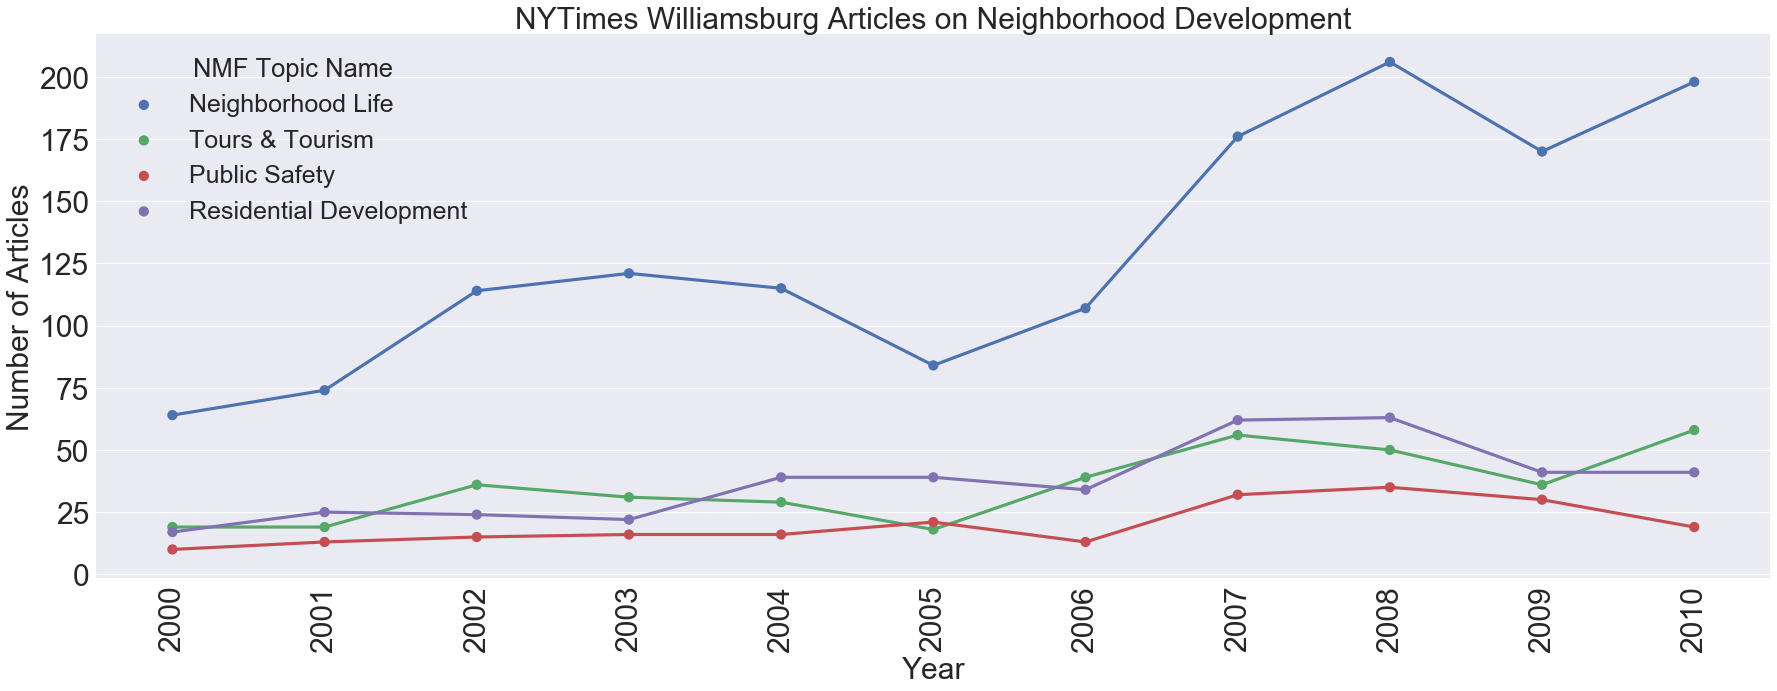

In [161]:
rc={'xtick.labelsize': 30, 'ytick.labelsize': 30, 'axes.labelsize': 30, 'font.size': 30, 'legend.fontsize': 25.0, 'axes.titlesize': 30, "figure.figsize": [30, 10]}
sns.set(rc=rc)
one_topic_NMF = final_df_NMF[final_df_NMF["NMF Overall Topic"] == "Neighborhood Development"]
g = sns.pointplot(ci = None, x = one_topic_NMF["Year"], y = one_topic_NMF["value"], order = order, hue = one_topic_NMF["NMF Topic Name"])
plt.xticks(rotation=90)
g.set(xlabel = "Year", ylabel = "Number of Articles", title = "NYTimes Williamsburg Articles on Neighborhood Development")
# plt.savefig("Policy_Articles.png", bbox_inches='tight')

[Text(0,0.5,u'Number of Articles'),
 Text(0.5,0,u'Year'),
 Text(0.5,1,u'NYTimes Williamsburg Articles on Entertainment & Leisure')]

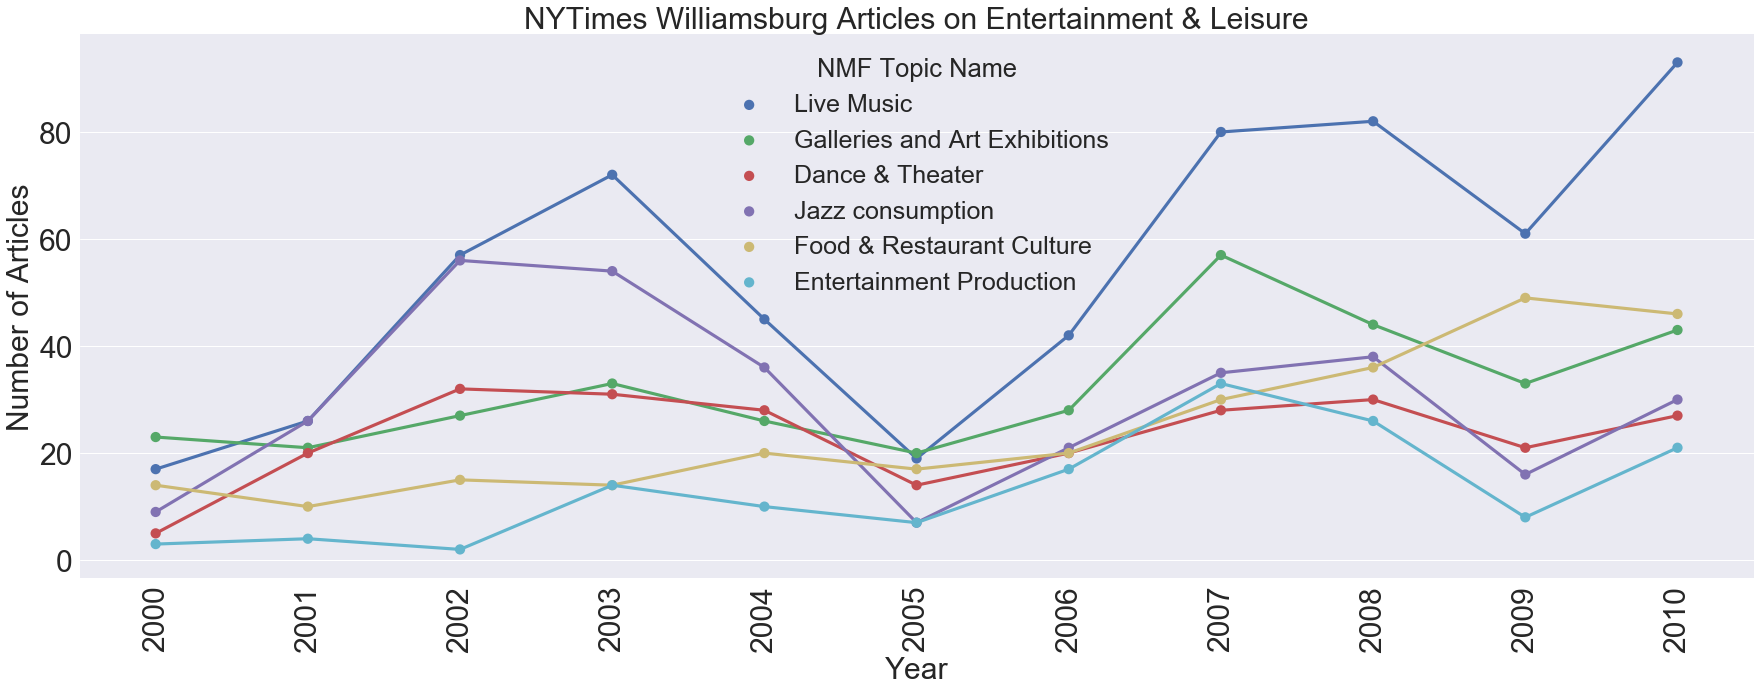

In [162]:
rc={'xtick.labelsize': 30, 'ytick.labelsize': 30, 'axes.labelsize': 30, 'font.size': 30, 'legend.fontsize': 25.0, 'axes.titlesize': 30, "figure.figsize": [30, 10]}
sns.set(rc=rc)
one_topic_NMF = final_df_NMF[final_df_NMF["NMF Overall Topic"] == "Entertainment & Leisure"]
g = sns.pointplot(ci = None, x = one_topic_NMF["Year"], y = one_topic_NMF["value"], order = order, hue = one_topic_NMF["NMF Topic Name"])
plt.xticks(rotation=90)
g.set(xlabel = "Year", ylabel = "Number of Articles", title = "NYTimes Williamsburg Articles on Entertainment & Leisure")
# plt.savefig("Policy_Articles.png", bbox_inches='tight')

## NMF Probability Charts

[Text(0,0.5,u'Probability'),
 Text(0.5,0,u'Year'),
 Text(0.5,1,u'NYTimes Williamsburg Articles on Entertainment & Leisure')]

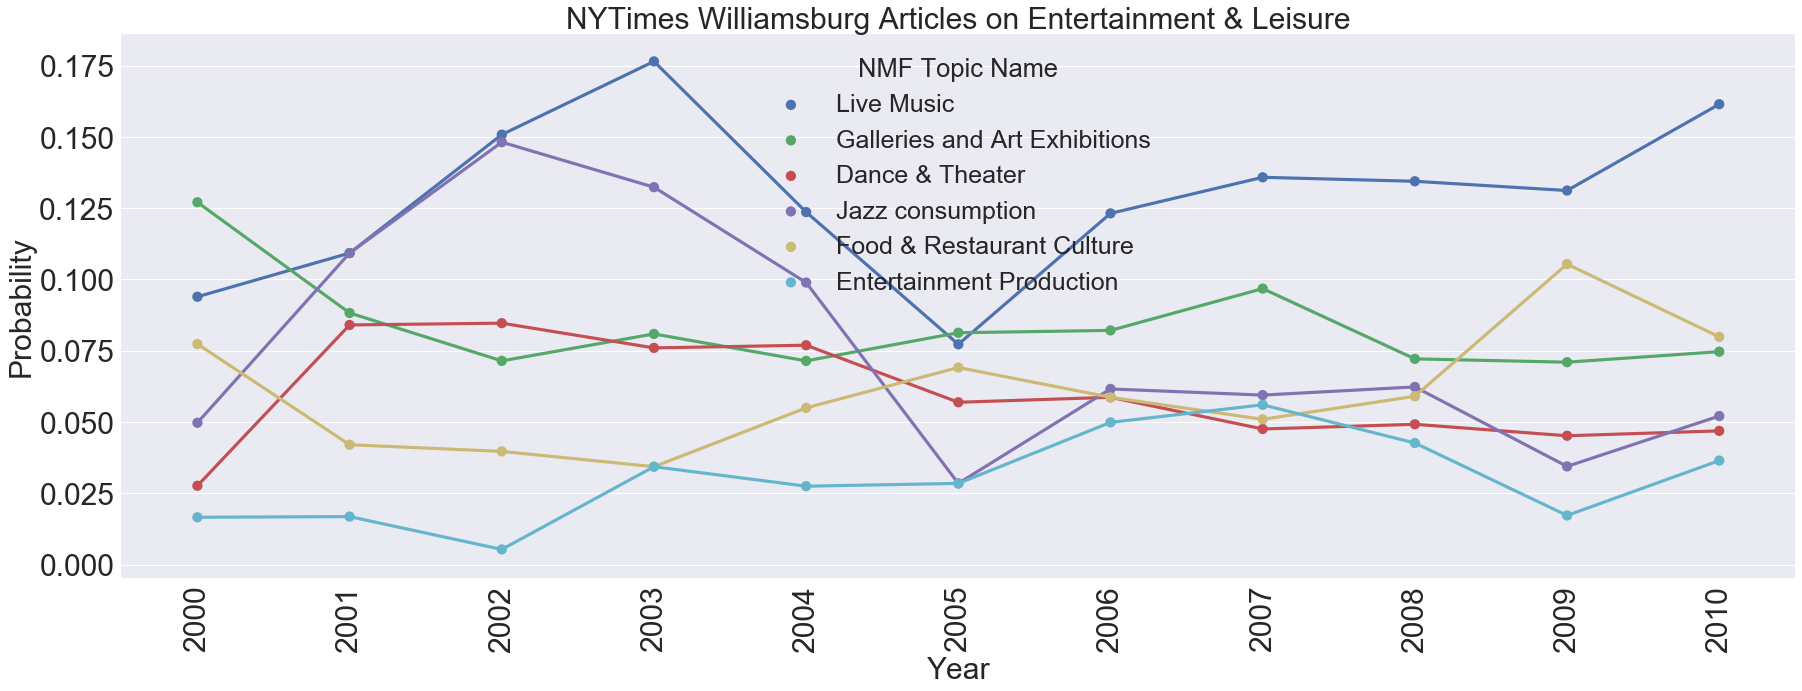

In [195]:
rc={'xtick.labelsize': 30, 'ytick.labelsize': 30, 'axes.labelsize': 30, 'font.size': 30, 'legend.fontsize': 25.0, 'axes.titlesize': 30, "figure.figsize": [30, 10]}
sns.set(rc=rc)
one_topic = pro_df_NMF[pro_df_NMF["NMF Overall Topic"] == "Entertainment & Leisure"]
g = sns.pointplot(ci = None, x = one_topic["Year"], y = one_topic["Topic Probability"], order = order, hue = one_topic["NMF Topic Name"])
plt.xticks(rotation=90)
g.set(xlabel = "Year", ylabel = "Probability", title = "NYTimes Williamsburg Articles on Entertainment & Leisure")
# plt.savefig("Policy_Articles.png", bbox_inches='tight')

[Text(0,0.5,u'Probability'),
 Text(0.5,0,u'Year'),
 Text(0.5,1,u'NYTimes Williamsburg Articles on Neighborhood Development')]

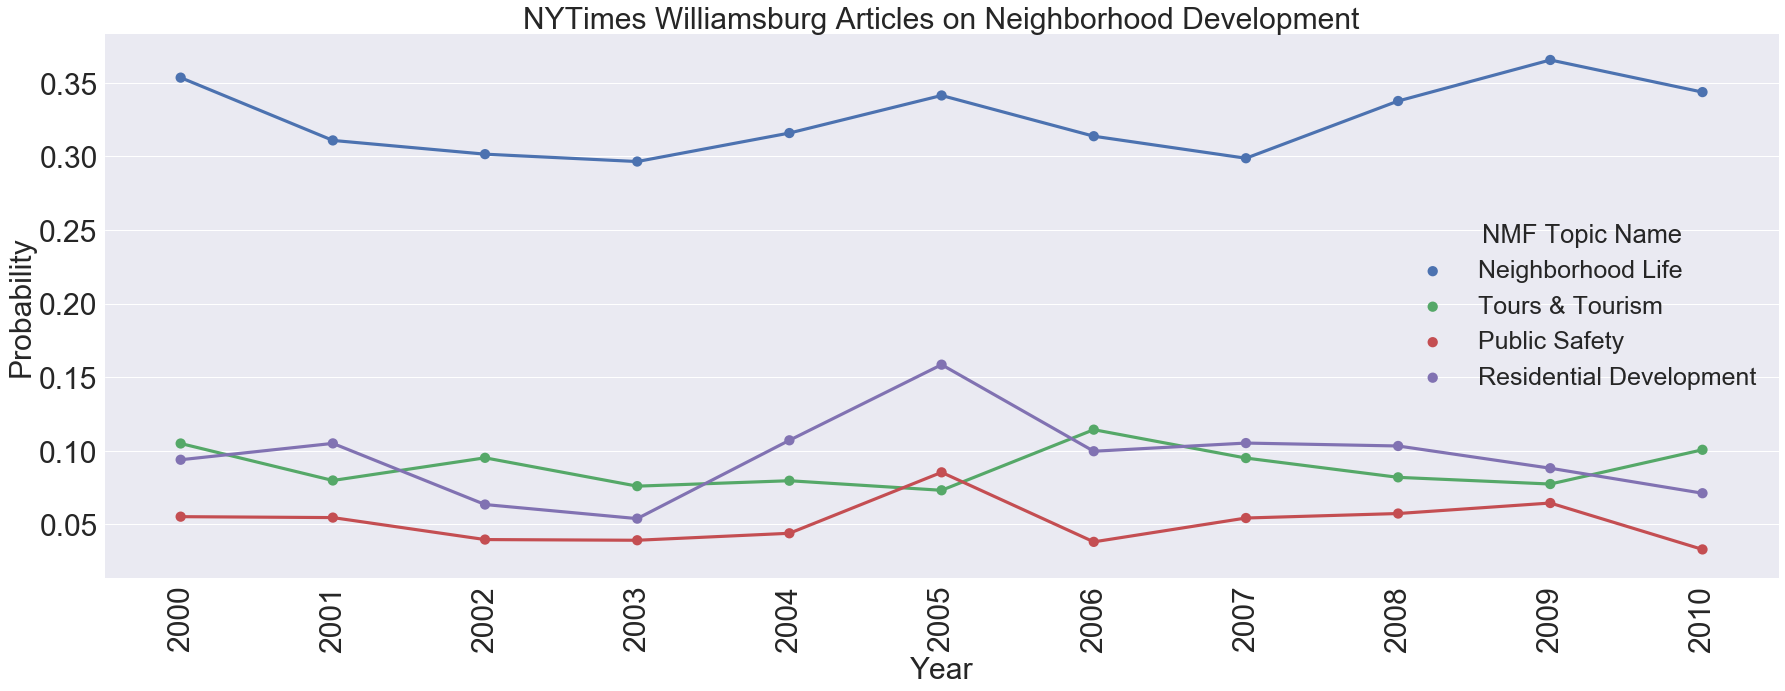

In [196]:
rc={'xtick.labelsize': 30, 'ytick.labelsize': 30, 'axes.labelsize': 30, 'font.size': 30, 'legend.fontsize': 25.0, 'axes.titlesize': 30, "figure.figsize": [30, 10]}
sns.set(rc=rc)
one_topic = pro_df_NMF[pro_df_NMF["NMF Overall Topic"] == "Neighborhood Development"]
g = sns.pointplot(ci = None, x = one_topic["Year"], y = one_topic["Topic Probability"], order = order, hue = one_topic["NMF Topic Name"])
plt.xticks(rotation=90)
g.set(xlabel = "Year", ylabel = "Probability", title = "NYTimes Williamsburg Articles on Neighborhood Development")
# plt.savefig("Policy_Articles.png", bbox_inches='tight')

## Generate Visualization for LDA

In [163]:
def incl_thresh(x): 
    if x >= 0.1:
        return 1
    else:
        return x

In [164]:
#NMF Topic Names
LDA_Topic_Names = {0: "Entertainment Production",
               1: "Tours & Tourism",
               2: "Music Consumption",
               3: "Neighborhood Culture",
               4: "Dining Out",
               5: "Real Estate Development",
               6: "Galleries & Art Exhibitions",
               7: "Fashion & Retail", 
               8: "Live Music", 
              9: "Dance & Theater"}

In [165]:
transformed_data_lda = lda.transform(tf)

In [166]:
for line in transformed_data_lda:
    print line

[  5.58796931e-04   5.58799991e-04   5.58841949e-04   2.07715969e-01
   5.58826973e-04   6.46606494e-01   5.58749193e-04   1.41765713e-01
   5.58893407e-04   5.58915600e-04]
[  2.41640024e-04   3.65878394e-02   2.41615299e-04   4.64852485e-02
   2.41624461e-04   8.15169164e-01   2.41602455e-04   6.77554395e-02
   3.27942026e-02   2.41623318e-04]
[  2.39308149e-04   2.16232864e-01   2.39304397e-04   2.39313065e-04
   2.39310153e-04   1.42397299e-01   2.39319942e-04   6.39694629e-01
   2.39326816e-04   2.39325615e-04]
[  2.94204244e-04   2.94193096e-04   2.94188567e-04   1.07908682e-01
   2.94188862e-04   2.94208520e-04   2.17384482e-01   6.72647464e-01
   2.94182483e-04   2.94205338e-04]
[  1.60812779e-04   1.60809555e-04   1.60814624e-04   1.60813891e-04
   9.70214684e-01   1.60813035e-04   2.84988258e-02   1.60815489e-04
   1.60803396e-04   1.60807410e-04]
[ 0.02732126  0.0010002   0.00100033  0.15916335  0.41307954  0.08223909
  0.00100027  0.31319558  0.00100019  0.00100018]
[  1.67

[  3.13539337e-04   3.13549314e-04   3.13539296e-04   3.13535241e-04
   3.13538674e-04   9.97178113e-01   3.13551984e-04   3.13534903e-04
   3.13537678e-04   3.13560450e-04]
[  2.06238167e-04   2.06225627e-04   2.06249997e-04   2.06242069e-04
   2.06245706e-04   2.06226505e-04   2.06231765e-04   2.06239057e-04
   9.98143870e-01   2.06231525e-04]
[  1.74264073e-04   1.74258062e-04   1.74264477e-04   1.74267647e-04
   1.74252404e-04   1.74261406e-04   1.21362556e-02   9.86469664e-01
   1.74254706e-04   1.74257713e-04]
[  1.52471720e-04   1.52470512e-04   1.52467552e-04   1.52477928e-04
   1.52468457e-04   9.98627755e-01   1.52475027e-04   1.52477950e-04
   1.52466443e-04   1.52469291e-04]
[  1.04631521e-04   1.04633116e-04   1.04630345e-04   1.04629705e-04
   1.04629386e-04   1.04624825e-04   1.04633936e-04   1.04626606e-04
   1.95393987e-01   8.03768973e-01]
[  1.38743926e-04   4.81154686e-03   1.38737172e-04   1.38765532e-04
   1.38740623e-04   1.38763767e-04   1.38756819e-04   1.38738

  0.07540349  0.22226918  0.04297245  0.00047401]
[  9.17645472e-04   9.17647335e-04   9.17655446e-04   9.17625034e-04
   9.91741182e-01   9.17753954e-04   9.17586322e-04   9.17704591e-04
   9.17637600e-04   9.17561861e-04]
[  2.17447725e-04   3.34935421e-02   9.27685026e-02   3.36358951e-01
   2.17466823e-04   2.17454579e-04   2.17451587e-04   5.02706092e-01
   2.17462960e-04   3.35856290e-02]
[ 0.00111133  0.00111134  0.00111137  0.00111149  0.34321182  0.2655803
  0.00111132  0.38342829  0.00111144  0.00111129]
[  1.86625969e-04   1.86621875e-04   7.64404090e-01   1.44467097e-01
   1.86630692e-04   6.59795534e-02   2.40295206e-02   1.86622790e-04
   1.86617098e-04   1.86620939e-04]
[  3.73231738e-04   3.73221344e-04   8.90840240e-02   3.73227819e-04
   4.38414055e-01   4.69889299e-01   3.73231437e-04   3.73244858e-04
   3.73238602e-04   3.73225675e-04]
[  5.07723354e-04   5.07781507e-04   5.07901182e-04   5.07722975e-04
   5.07722355e-04   7.85957037e-01   6.41206175e-02   1.4636786

[  5.18216612e-04   5.18229297e-04   5.18236681e-04   5.18281256e-04
   5.18257983e-04   5.69014110e-01   5.18224448e-04   4.26840020e-01
   5.18212860e-04   5.18210814e-04]
[  2.51328230e-04   2.24892395e-02   2.17487483e-01   2.51314381e-04
   2.51400069e-04   2.51319884e-04   2.51317586e-04   2.51337025e-04
   7.58263946e-01   2.51314259e-04]
[  5.18236786e-04   1.31419749e-01   5.18257688e-04   5.18292607e-04
   5.18260701e-04   5.32620299e-01   5.18287268e-04   3.32332102e-01
   5.18243355e-04   5.18271293e-04]
[  3.63725491e-04   3.63735280e-04   3.63745661e-04   8.22681621e-02
   1.60002630e-01   2.09039444e-01   3.63745107e-04   4.66463585e-01
   4.12184560e-02   3.95527718e-02]
[  3.58535862e-04   3.58509138e-04   1.24263974e-01   2.35052891e-02
   3.58544192e-04   3.58510215e-04   3.58529987e-04   8.49721036e-01
   3.58526890e-04   3.58544559e-04]
[  2.44569807e-04   9.97798813e-01   2.44573748e-04   2.44569066e-04
   2.44576217e-04   2.44574401e-04   2.44575739e-04   2.44584

   5.99023793e-04   5.99045302e-04]
[  3.92265580e-04   1.22618167e-01   3.92274341e-04   3.92271031e-04
   4.73761291e-01   3.92278618e-04   3.92228756e-04   3.32307657e-01
   6.89593384e-02   3.92228835e-04]
[  4.56723233e-04   4.56769256e-04   4.56717583e-04   9.99406838e-02
   1.83156661e-01   7.09647811e-01   4.56706309e-04   4.51442019e-03
   4.56738891e-04   4.56767933e-04]
[  4.78620243e-04   5.29722893e-02   8.08410683e-02   4.78564130e-04
   4.78670249e-04   8.41920079e-01   4.78615918e-04   4.78602461e-04
   4.78601986e-04   2.13948880e-02]
[  3.67739881e-04   3.67735402e-04   3.67785849e-04   3.67747928e-04
   3.67751005e-04   7.24852929e-01   3.67729563e-04   2.72205097e-01
   3.67754403e-04   3.67729744e-04]
[  1.82536135e-04   9.68291659e-01   1.82537520e-04   1.82522663e-04
   1.82524024e-04   1.82524573e-04   1.82537617e-04   1.82524323e-04
   1.82547975e-04   3.02480859e-02]
[  3.48141745e-02   5.62006826e-04   5.61946185e-04   5.61965047e-04
   5.62002079e-04   5.619

[ 0.0009807   0.00098056  0.00098065  0.52269791  0.46945703  0.00098062
  0.00098055  0.00098061  0.00098065  0.00098074]
[  7.75444142e-04   7.75413266e-04   7.75389291e-04   7.82371389e-02
   7.75469865e-04   9.81996171e-02   7.75384840e-04   8.18135392e-01
   7.75330971e-04   7.75419594e-04]
[  3.50989135e-04   6.07543964e-02   6.45982389e-02   2.77665868e-02
   3.50977092e-04   7.92521561e-01   3.50987916e-04   5.26043219e-02
   3.50963938e-04   3.50977335e-04]
[ 0.00135177  0.00135173  0.00135186  0.0013517   0.98783444  0.00135169
  0.00135159  0.0013519   0.00135173  0.00135158]
[ 0.00384674  0.00384687  0.00384726  0.00384686  0.64862444  0.00384693
  0.00384693  0.32059998  0.00384722  0.00384676]
[ 0.0010313   0.0010311   0.00103123  0.00103119  0.20366818  0.0010312
  0.34744835  0.44166503  0.00103118  0.00103124]
[ 0.14968028  0.43301993  0.00238185  0.25608187  0.00238157  0.00238188
  0.14692785  0.00238171  0.00238158  0.00238148]
[ 0.00065377  0.00065373  0.17826733  

[ 0.00303103  0.00303101  0.00303095  0.00303128  0.45319062  0.00303089
  0.13878876  0.38680324  0.00303115  0.00303107]
[  2.98597008e-02   8.32149241e-02   2.38168375e-04   2.90845119e-01
   4.17973402e-01   1.76916041e-01   2.38157172e-04   2.38167275e-04
   2.38176013e-04   2.38144343e-04]
[  2.63933040e-04   2.63933646e-04   2.53806899e-01   2.63935382e-04
   2.63926821e-04   2.63914541e-04   2.63932540e-04   2.63924471e-04
   7.20904273e-01   2.34413274e-02]
[  3.07768068e-04   8.93322341e-02   2.52019752e-01   3.07773711e-04
   3.07783328e-04   3.07773973e-04   3.07782589e-04   3.07778240e-04
   6.56493576e-01   3.07777764e-04]
[  3.53418593e-04   4.58537516e-02   3.53469904e-04   4.05313994e-01
   6.62873539e-02   2.03422829e-01   3.53460543e-04   2.77354799e-01
   3.53461283e-04   3.53462797e-04]
[ 0.0004903   0.00049033  0.00049028  0.40048974  0.18117185  0.21747421
  0.00049029  0.1979224   0.00049027  0.00049032]
[ 0.00054964  0.00054961  0.00054961  0.53817935  0.000549

In [167]:
transformed_data_LDA = pd.DataFrame(transformed_data_lda)
article_topics_LDA = transformed_data_LDA.applymap(incl_thresh)
raw_data_LDA = raw_no_duplicates.reset_index()
article_topics_LDA["Date"] = raw_data_LDA["Date_by_Month"]
article_topics_LDA["Year"] = raw_data_LDA["Year"]
article_topics_LDA["Article_Num"] = range(1, len(article_topics_LDA) + 1)
melted_df_LDA = pd.melt(article_topics_LDA, id_vars = ["Article_Num", "Date", "Year"], var_name = "Topic_Num")

In [117]:
#melted_df_LDA = melted_df_LDA[-melted_df_LDA["Topic_Num"].isin([0, 10])]

In [168]:
topic_num_to_name_LDA = pd.DataFrame.from_dict(LDA_Topic_Names, orient = "index").reset_index()
topic_num_to_name_LDA.columns = ["Topic_Num", "LDA_Topic_Name"]
final_df_LDA = melted_df_LDA.merge(topic_num_to_name_LDA, on = "Topic_Num")

In [169]:
final_df_LDA

,Article_Num,Date,Year,Topic_Num,value,LDA_Topic_Name
0,1,01-2000,2000,0,0.000559,Entertainment Production
1,2,01-2000,2000,0,0.000242,Entertainment Production
2,3,01-2000,2000,0,0.000239,Entertainment Production
3,4,01-2000,2000,0,0.000294,Entertainment Production
4,5,01-2000,2000,0,0.000161,Entertainment Production
5,6,02-2000,2000,0,0.027321,Entertainment Production
6,7,02-2000,2000,0,0.016747,Entertainment Production
7,8,02-2000,2000,0,0.000417,Entertainment Production
8,9,02-2000,2000,0,0.000307,Entertainment Production
9,10,02-2000,2000,0,0.001124,Entertainment Production


In [170]:
#OVERALL LDA TOPICS
overall_LDA_topic = pd.DataFrame({"Entertainment & Leisure": [0,2,4,6,8,9],
                     "Neighborhood Development": [1,3,5,7,"Nan","Nan"]})
melted_ot_LDA = pd.melt(overall_LDA_topic)
melted_ot_LDA = melted_ot_LDA[melted_ot_LDA["value"] != "NaN"]
melted_ot_LDA.columns = ["LDA Overall Topic", "Topic_Num"]

In [171]:
melted_ot_LDA

,LDA Overall Topic,Topic_Num
0,Entertainment & Leisure,0
1,Entertainment & Leisure,2
2,Entertainment & Leisure,4
3,Entertainment & Leisure,6
4,Entertainment & Leisure,8
5,Entertainment & Leisure,9
6,Neighborhood Development,1
7,Neighborhood Development,3
8,Neighborhood Development,5
9,Neighborhood Development,7


In [172]:
final_df_LDA = final_df_LDA.merge(melted_ot_LDA, on = "Topic_Num")

In [173]:
final_df_LDA = final_df_LDA.groupby(["Year", "Topic_Num", "LDA_Topic_Name", "LDA Overall Topic"]).sum().reset_index()

In [174]:
final_df_LDA

,Year,Topic_Num,LDA_Topic_Name,LDA Overall Topic,Article_Num,value
0,2000,0,Entertainment Production,Entertainment & Leisure,2080,2.225346
1,2000,1,Tours & Tourism,Neighborhood Development,2080,9.310251
2,2000,2,Music Consumption,Entertainment & Leisure,2080,7.404907
3,2000,3,Neighborhood Culture,Neighborhood Development,2080,15.088909
4,2000,4,Dining Out,Entertainment & Leisure,2080,19.549543
5,2000,5,Real Estate Development,Neighborhood Development,2080,29.447788
6,2000,6,Galleries & Art Exhibitions,Entertainment & Leisure,2080,14.185346
7,2000,7,Fashion & Retail,Neighborhood Development,2080,32.398678
8,2000,8,Live Music,Entertainment & Leisure,2080,9.275768
9,2000,9,Dance & Theater,Entertainment & Leisure,2080,5.135097


In [177]:
final_sum_LDA = final_df_LDA.groupby(["Year"])["value"].sum().reset_index()

In [178]:
final_sum_LDA

,Year,value
0,2000,144.021633
1,2001,150.843824
2,2002,186.567222
3,2003,218.661600
4,2004,243.064632
5,2005,195.437631
6,2006,245.339724
7,2007,382.800357
8,2008,445.321129
9,2009,386.739897


In [180]:
pro_df_LDA=pd.merge(left=final_df_LDA, right=final_sum_LDA, left_on='Year',right_on='Year',how='left')
pro_df_LDA

,Year,Topic_Num,LDA_Topic_Name,LDA Overall Topic,Article_Num,value_x,value_y
0,2000,0,Entertainment Production,Entertainment & Leisure,2080,2.225346,144.021633
1,2000,1,Tours & Tourism,Neighborhood Development,2080,9.310251,144.021633
2,2000,2,Music Consumption,Entertainment & Leisure,2080,7.404907,144.021633
3,2000,3,Neighborhood Culture,Neighborhood Development,2080,15.088909,144.021633
4,2000,4,Dining Out,Entertainment & Leisure,2080,19.549543,144.021633
5,2000,5,Real Estate Development,Neighborhood Development,2080,29.447788,144.021633
6,2000,6,Galleries & Art Exhibitions,Entertainment & Leisure,2080,14.185346,144.021633
7,2000,7,Fashion & Retail,Neighborhood Development,2080,32.398678,144.021633
8,2000,8,Live Music,Entertainment & Leisure,2080,9.275768,144.021633
9,2000,9,Dance & Theater,Entertainment & Leisure,2080,5.135097,144.021633


In [183]:
pro_df_LDA.loc[:,"Topic Probability"]=pro_df_LDA.value_x /pro_df_LDA.value_y
pro_df_LDA = pro_df_LDA.rename(index=str, columns={"value_x": "Topic Sum", "value_y": "Year Sum", "LDA_Topic_Name": "Topic Name"})
pro_df_LDA

,Year,Topic_Num,Topic Name,LDA Overall Topic,Article_Num,Topic Sum,Year Sum,Probability,Topic Probability
0,2000,0,Entertainment Production,Entertainment & Leisure,2080,2.225346,144.021633,0.015451,0.015451
1,2000,1,Tours & Tourism,Neighborhood Development,2080,9.310251,144.021633,0.064645,0.064645
2,2000,2,Music Consumption,Entertainment & Leisure,2080,7.404907,144.021633,0.051415,0.051415
3,2000,3,Neighborhood Culture,Neighborhood Development,2080,15.088909,144.021633,0.104768,0.104768
4,2000,4,Dining Out,Entertainment & Leisure,2080,19.549543,144.021633,0.135740,0.135740
5,2000,5,Real Estate Development,Neighborhood Development,2080,29.447788,144.021633,0.204468,0.204468
6,2000,6,Galleries & Art Exhibitions,Entertainment & Leisure,2080,14.185346,144.021633,0.098495,0.098495
7,2000,7,Fashion & Retail,Neighborhood Development,2080,32.398678,144.021633,0.224957,0.224957
8,2000,8,Live Music,Entertainment & Leisure,2080,9.275768,144.021633,0.064405,0.064405
9,2000,9,Dance & Theater,Entertainment & Leisure,2080,5.135097,144.021633,0.035655,0.035655


## Frequency Charts for LDA

[Text(0,0.5,u'Number of Articles'),
 Text(0.5,0,u'Year'),
 Text(0.5,1,u'NYTimes Williamsburg Articles on Neighborhood Development')]

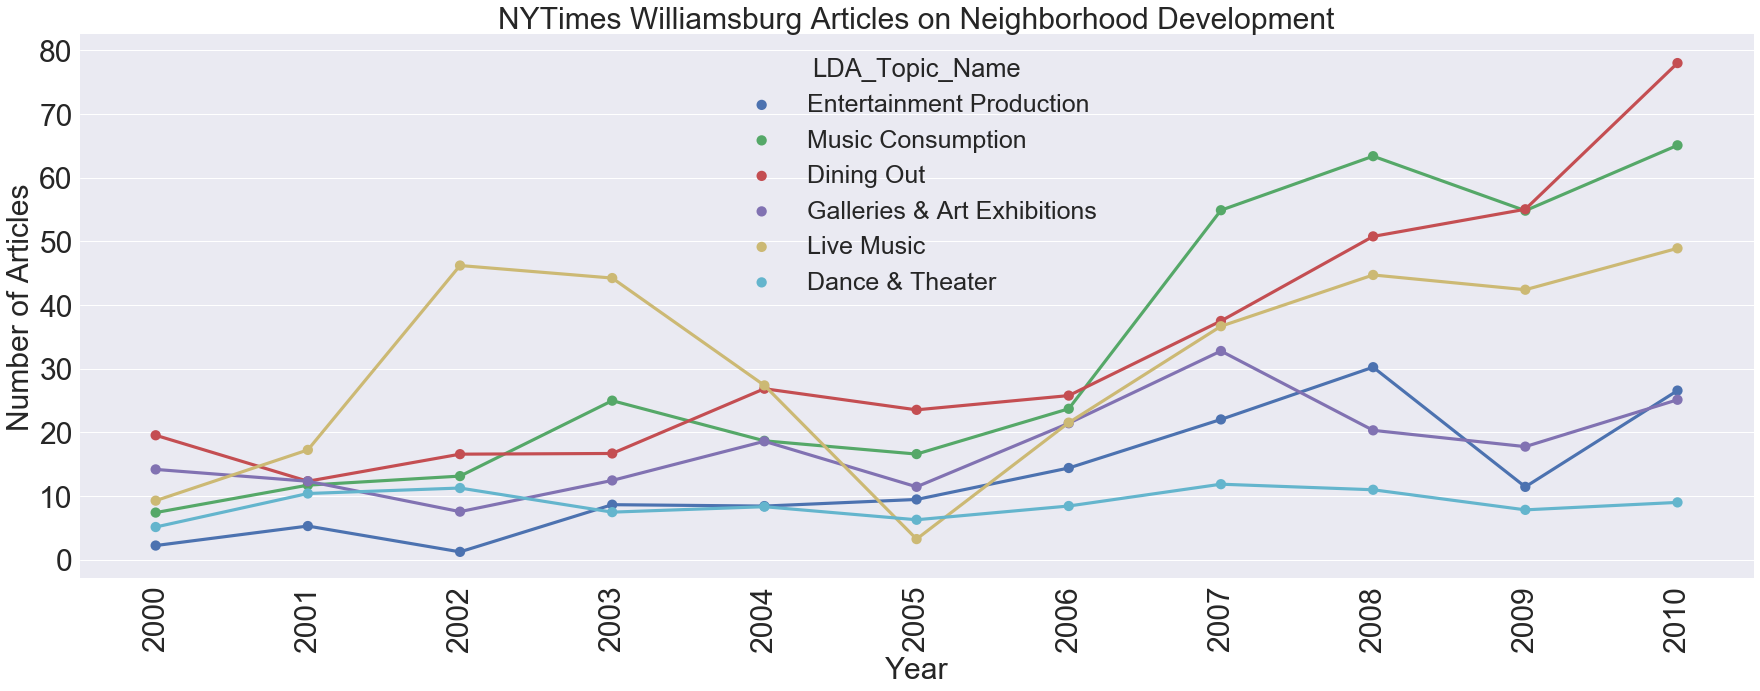

In [175]:
rc={'xtick.labelsize': 30, 'ytick.labelsize': 30, 'axes.labelsize': 30, 'font.size': 30, 'legend.fontsize': 25.0, 'axes.titlesize': 30, "figure.figsize": [30, 10]}
sns.set(rc=rc)
one_topic = final_df_LDA[final_df_LDA["LDA Overall Topic"] == "Entertainment & Leisure"]
g = sns.pointplot(ci = None, x = one_topic["Year"], y = one_topic["value"], order = order, hue = one_topic["LDA_Topic_Name"])
plt.xticks(rotation=90)
g.set(xlabel = "Year", ylabel = "Number of Articles", title = "NYTimes Williamsburg Articles on Neighborhood Development")
# plt.savefig("Policy_Articles.png", bbox_inches='tight')

[Text(0,0.5,u'Number of Articles'),
 Text(0.5,0,u'Year'),
 Text(0.5,1,u'NYTimes Williamsburg Articles on Neighborhood Development')]

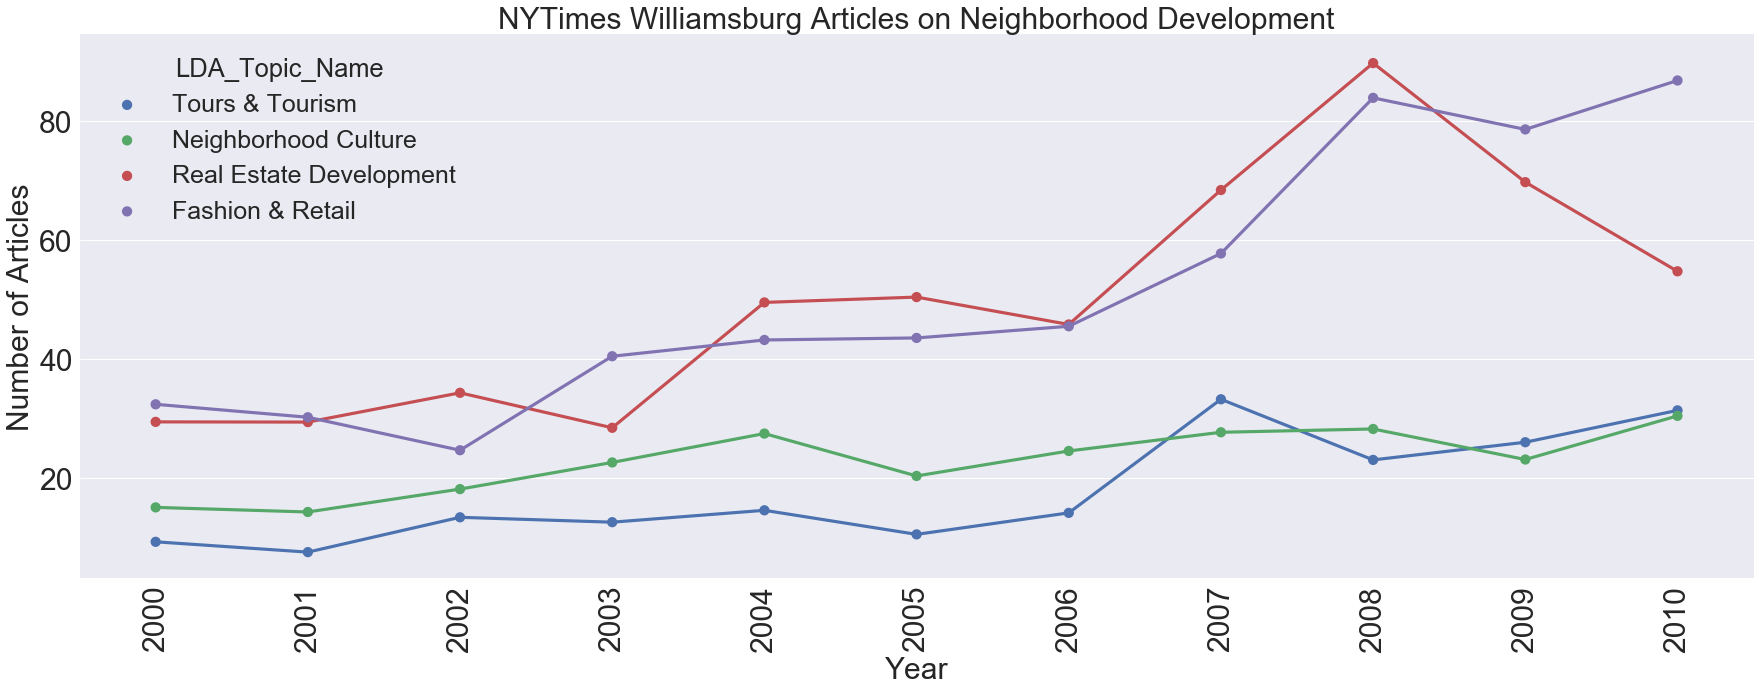

In [176]:
rc={'xtick.labelsize': 30, 'ytick.labelsize': 30, 'axes.labelsize': 30, 'font.size': 30, 'legend.fontsize': 25.0, 'axes.titlesize': 30, "figure.figsize": [30, 10]}
sns.set(rc=rc)
one_topic = final_df_LDA[final_df_LDA["LDA Overall Topic"] == "Neighborhood Development"]
g = sns.pointplot(ci = None, x = one_topic["Year"], y = one_topic["value"], order = order, hue = one_topic["LDA_Topic_Name"])
plt.xticks(rotation=90)
g.set(xlabel = "Year", ylabel = "Number of Articles", title = "NYTimes Williamsburg Articles on Neighborhood Development")
# plt.savefig("Policy_Articles.png", bbox_inches='tight')

## Probability Charts LDA

[Text(0,0.5,u'Probability'),
 Text(0.5,0,u'Year'),
 Text(0.5,1,u'NYTimes Williamsburg Articles on Neighborhood Development')]

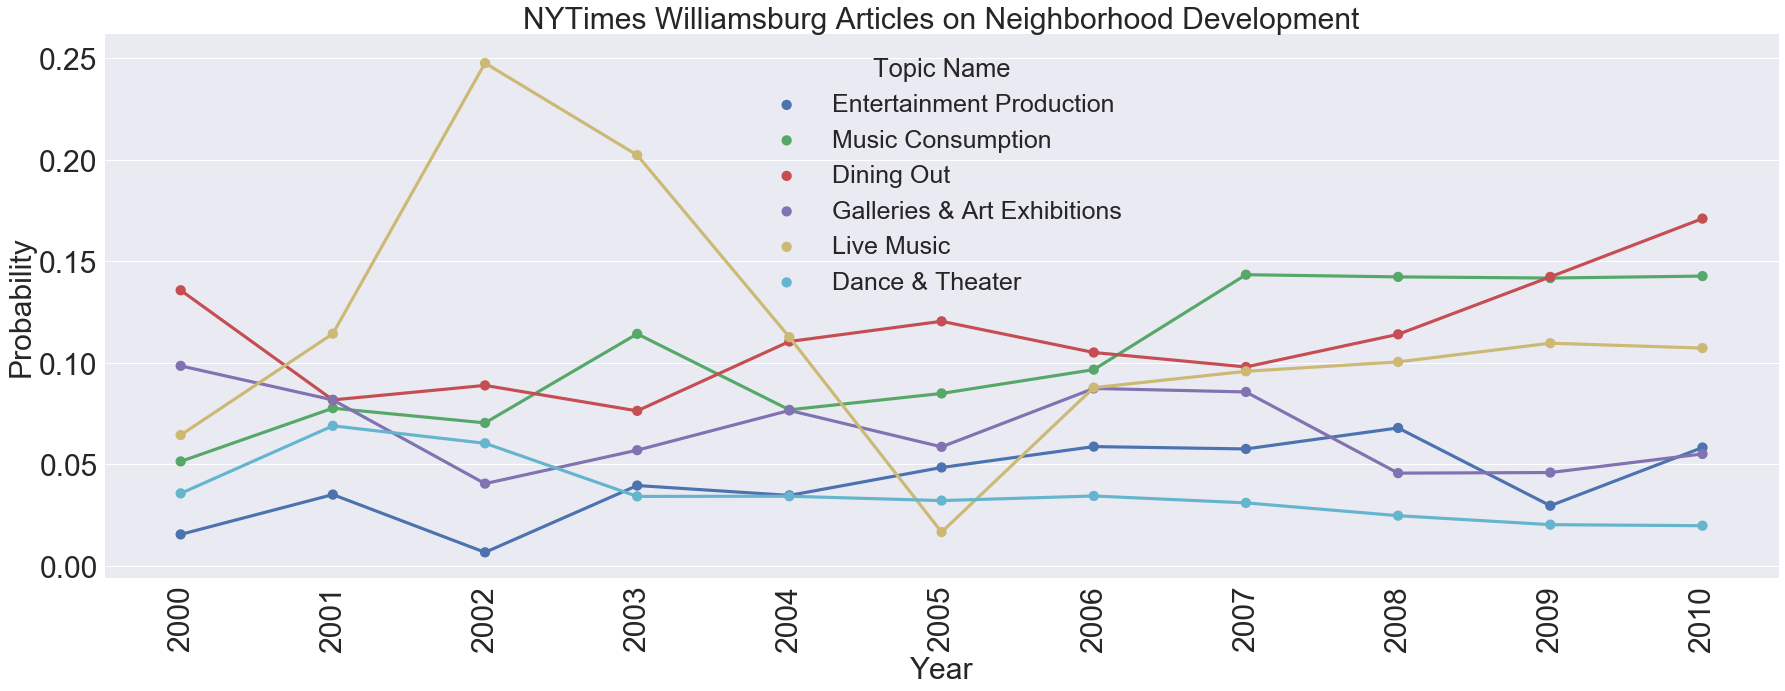

In [187]:
rc={'xtick.labelsize': 30, 'ytick.labelsize': 30, 'axes.labelsize': 30, 'font.size': 30, 'legend.fontsize': 25.0, 'axes.titlesize': 30, "figure.figsize": [30, 10]}
sns.set(rc=rc)
one_topic = pro_df_LDA[pro_df_LDA["LDA Overall Topic"] == "Entertainment & Leisure"]
g = sns.pointplot(ci = None, x = one_topic["Year"], y = one_topic["Topic Probability"], order = order, hue = one_topic["Topic Name"])
plt.xticks(rotation=90)
g.set(xlabel = "Year", ylabel = "Probability", title = "NYTimes Williamsburg Articles on Neighborhood Development")
# plt.savefig("Policy_Articles.png", bbox_inches='tight')

[Text(0,0.5,u'Probability'),
 Text(0.5,0,u'Year'),
 Text(0.5,1,u'NYTimes Williamsburg Articles on Neighborhood Development')]

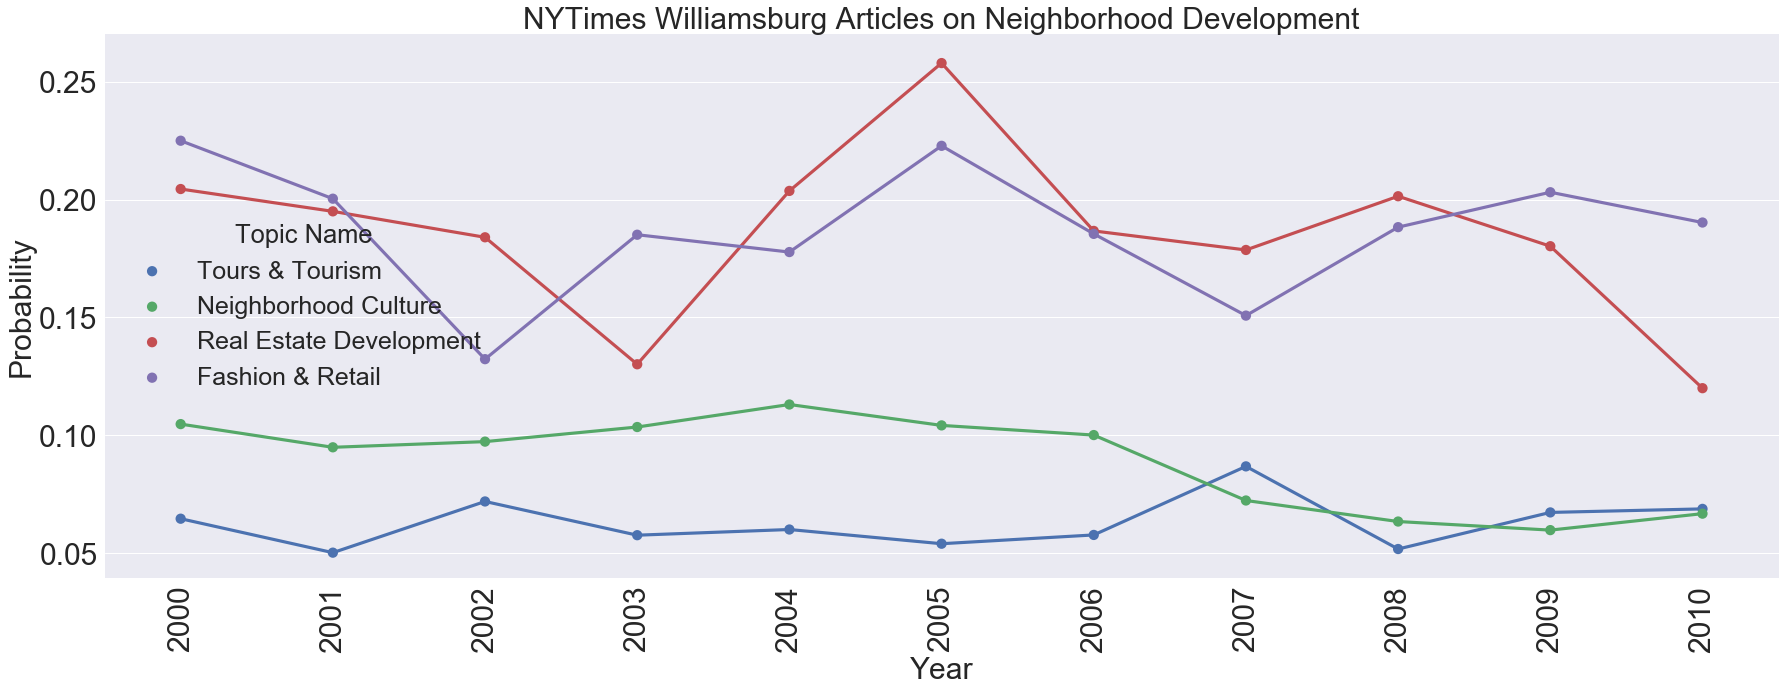

In [188]:
rc={'xtick.labelsize': 30, 'ytick.labelsize': 30, 'axes.labelsize': 30, 'font.size': 30, 'legend.fontsize': 25.0, 'axes.titlesize': 30, "figure.figsize": [30, 10]}
sns.set(rc=rc)
one_topic = pro_df_LDA[pro_df_LDA["LDA Overall Topic"] == "Neighborhood Development"]
g = sns.pointplot(ci = None, x = one_topic["Year"], y = one_topic["Topic Probability"], order = order, hue = one_topic["Topic Name"])
plt.xticks(rotation=90)
g.set(xlabel = "Year", ylabel = "Probability", title = "NYTimes Williamsburg Articles on Neighborhood Development")
# plt.savefig("Policy_Articles.png", bbox_inches='tight')